In [44]:
%matplotlib inline
import numpy as np
from ipywidgets import interactive, widgets
from matplotlib import pyplot as plt
from IPython.display import Image

### Cosmic Ray data from the Pierre Auger Observatory

This section utilises publically-available data from the Pierre Auger Observatory (PAO), detailing Ultra-High-energy Cosmic Ray (UHECR) events detected by the PAO. The Observatory consists of 1600 surface 1600 water cherenkov detectors, spaced roughly ~1.5km apart. There are 27 complemntary fluorescence detectors, so PAO is a "hybrid detector". The surface tanks gives PAO a huge surface area of ~3000km2, enabling it to observe the rare events from the high-energy tail of the Cosmic Ray spectrum (the "Ankle Region").

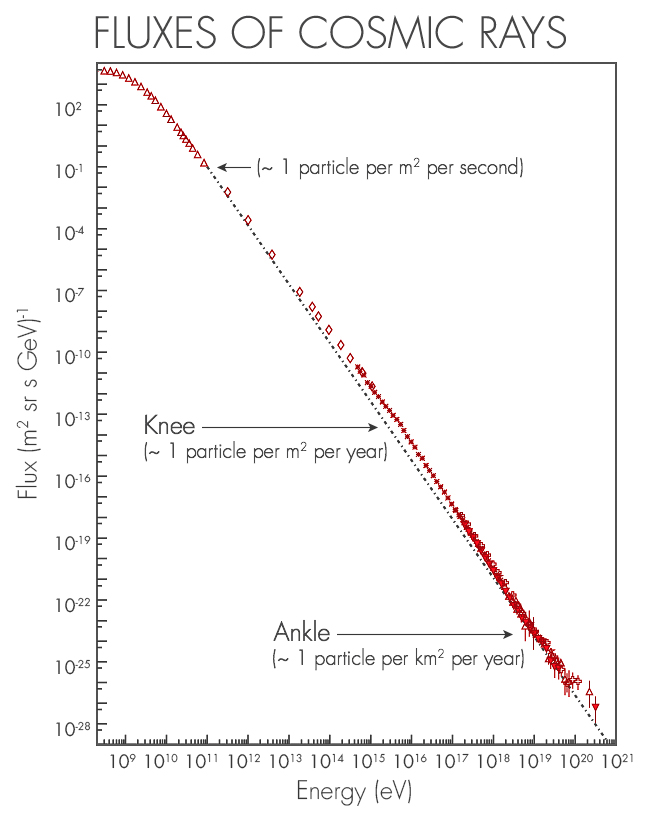

In [46]:
Image('https://d2r55xnwy6nx47.cloudfront.net/uploads/2015/05/SwordyCosmicRaySpectrum_v1.jpg',width=500)

The public data list all events with E > 8 EeV (10^18 eV), and zenith < 80 deg, from Jan 1 2004 up to 31 August 2016.

The columns in the data table are:

year day  dec   RA   azimuth weight (angles in deg)

In [41]:
auger_data = np.loadtxt("auger/events_a8.dat", skiprows=5, dtype=np.float)
print auger_data

[[ 2.004e+03  1.000e+00 -1.180e+01  2.089e+02  1.647e+02  1.004e+00]
 [ 2.004e+03  2.000e+00 -7.040e+01  3.660e+01 -1.116e+02  1.003e+00]
 [ 2.004e+03  3.000e+00 -4.780e+01  3.347e+02 -1.438e+02  9.980e-01]
 ...
 [ 2.016e+03  2.440e+02 -2.390e+01  9.920e+01  1.464e+02  9.971e-01]
 [ 2.016e+03  2.440e+02 -4.700e+01  1.225e+02 -1.457e+02  9.990e-01]
 [ 2.016e+03  2.440e+02 -4.520e+01  1.517e+02 -1.391e+02  9.998e-01]]


We can firstly look at the distribution of Cosmic Ray detections as a function of time. 

The Pierre Auger observatory began data-taking while surface tanks were stil being constructed, so the event rate increases with time. With finer binning, periods of downtime for the detector become visible.

In [47]:
arrival_times = auger_data[:,0] + auger_data[:,1]/365.

def arrival_hist(n_bins):
    plt.figure()
    plt.hist(arrival_times, bins=n_bins)
    plt.xlabel("Year")
    plt.ylabel("Detected Cosmic Rays")
    plt.show()
    
interactive(arrival_hist, n_bins=widgets.IntSlider(min=5,max=100,step=5, value=25))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0yNSwgZGVzY3JpcHRpb249dSduX2JpbnMnLCBtaW49NSwgc3RlcD01KSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXM9KHUnd2nigKY=


In [ ]:
The Pierre Auger